## Récuperation de données

In [12]:
#Libs
import os
import sys
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
sys.path.insert(0, "D:\\software_projects\\projet_pi\\o-kidia")
#toujours mis dans le chemin approprié
from src.data_manipulation.game_session.game_session import GameSession
from src.data_manipulation.game_session.challenge import CrocosMazeChallenge

In [13]:
#Variables utilisés
qtd_challenges = 14;

path = "../tests/game_session/dummy_data/"
dirs = os.listdir( path )

qtd_samples = 60;

#for file in dirs:
#   qtd_samples += 1

In [14]:
session=[0 for i in range(qtd_samples)]
for i in range(0, qtd_samples):
    session[i] = GameSession.from_json(os.path.join("..", "tests", "game_session", "dummy_data", "%s.json"%i))


## Normalization

In [15]:
# Utility Functions

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

            
def plot_challenges(session:GameSession, challenge:int, ax=None):
    curve_user = pd.DataFrame.from_records([{"x": point[0], "y": point[1], "t": point[2], "type": "user"} for point in session.sorted_activities[0].challenges[challenge].digit_curve()])
    sns.lineplot(x="x", y="y", data=curve_user, ax=ax, sort=False)

def list_track_challenge(challenge:int):
    tra_list = [0 for i in range(qtd_samples)]
    for i in range(0, qtd_samples):
        curve_user = pd.DataFrame.from_records([{"x": point[0], "y": point[1]} for point in session[i].sorted_activities[0].challenges[challenge].digit_curve()])
        tra_list[i] = curve_user.to_numpy();

    return tra_list

In [16]:
# Pour reduction_trajectoire_N2

def calculateDistance(x1 : float, y1: float, x2 : float, y2: float):
    p1 = [x1*0.25684, y1*0.16902]
    p2 = [x2*0.25684, y2*0.16902]
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    return(distance)

def calculateEuclidienne(array):
    dist = 0
    i=0
    x_user = np.zeros(len(array))
    y_user = np.zeros(len(array))
    
    for i in range(0,len(array)) :
        x_user[i] = array[i][0]
        y_user[i] = array[i][1]
    for i in range(0,len(x_user)-1):
        dist += calculateDistance(x_user[i], y_user[i], x_user[i+1], y_user[i+1])
    return(dist)

In [17]:

#2 Trajectory segmentation

def reduction_trajectoire_N1(tra_list):
    degree_threshold = 5
    for traj_index, traj in enumerate(tra_list):
        hold_index_lst = []
        previous_azimuth= 1000
        
        for point_index, point in enumerate(traj[:-1]):
            next_point = traj[point_index + 1]
            diff_vector = next_point - point
            azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
            
            if abs(azimuth - previous_azimuth) > degree_threshold:
                hold_index_lst.append(point_index)
                previous_azimuth = azimuth
        hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
        
        tra_list[traj_index] = traj[hold_index_lst, :]
    return tra_list

def reduction_trajectoire_N2(array):
    k=0
    length = len(array)
    xs = [0 for i in range(length)]
    ys = [0 for i in range(length)]
    for i in range(length):
        xs[i] = array[i][0]
        ys[i] = array[i][1]
    del xs[1:length:2]
    del ys[1:length:2]

    array2 = [[0,0] for i in range(len(xs))]
    for i in range(len(xs)):
        array2[i] = [xs[i],ys[i]]
    length = len(array2)
    for i in range(0,len(array2)-11, 10):
        for n in range(5):
            if(calculateEuclidienne(array2[i:i+n]) < 0.004):
                array2[i:i+n] = reduction_trajectoire_N2(array2[i:i+n])
    return (array2)

Normalization test round

55
16


<AxesSubplot:>

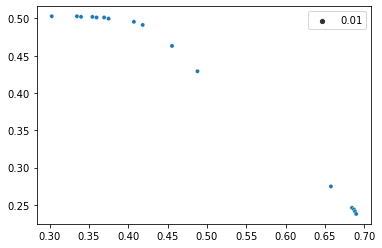

In [18]:
#Test round normalisation 1

challenge = 0                       #choix du challenge souhaité
sample = 45                         #choix sample souhaité

tra_list = list_track_challenge(challenge)

print(len(tra_list[sample]))        #quantite de points avant la normalization
reduction_trajectoire_N1(tra_list)  #enlever cette ligne pour avoir la courbe originale
print(len(tra_list[sample]))        #quantite de points apres la normalization
data = tra_list[sample]
xs = [0 for i in range(len(data))]
ys = [0 for i in range(len(data))]
for i in range(len(data)):
    xs[i] = data[i][0]
    ys[i] = data[i][1]
sns.scatterplot(x=xs, y=ys,size=0.01, ax=None)
        

55
25


<AxesSubplot:>

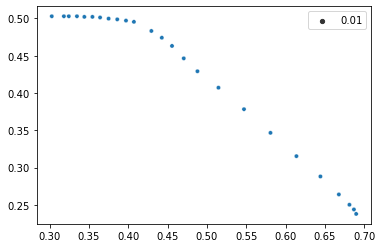

In [19]:
#Test round normalisation 2

challenge = 0                                       #choix du challenge souhaité
sample = 45                                         #choix sample souhaité

tra_list = list_track_challenge(challenge)

print(len(tra_list[sample]))
data = reduction_trajectoire_N2(tra_list[sample])   #enlever cette ligne pour avoir la courbe originale
print(len(data))                                    #quantite de points apres la normalization
xs = [0 for i in range(len(data))]
ys = [0 for i in range(len(data))]
for i in range(len(data)):
    xs[i] = data[i][0]
    ys[i] = data[i][1]
sns.scatterplot(x=xs, y=ys,size=0.01, ax=None)

## Trajectory Similarity

In [20]:
from sklearn.cluster import DBSCAN
from os.path import dirname, join
from scipy.spatial.distance import directed_hausdorff

In [21]:
#Variables utilisés
list_eps = [];
list_n_clusters = [];

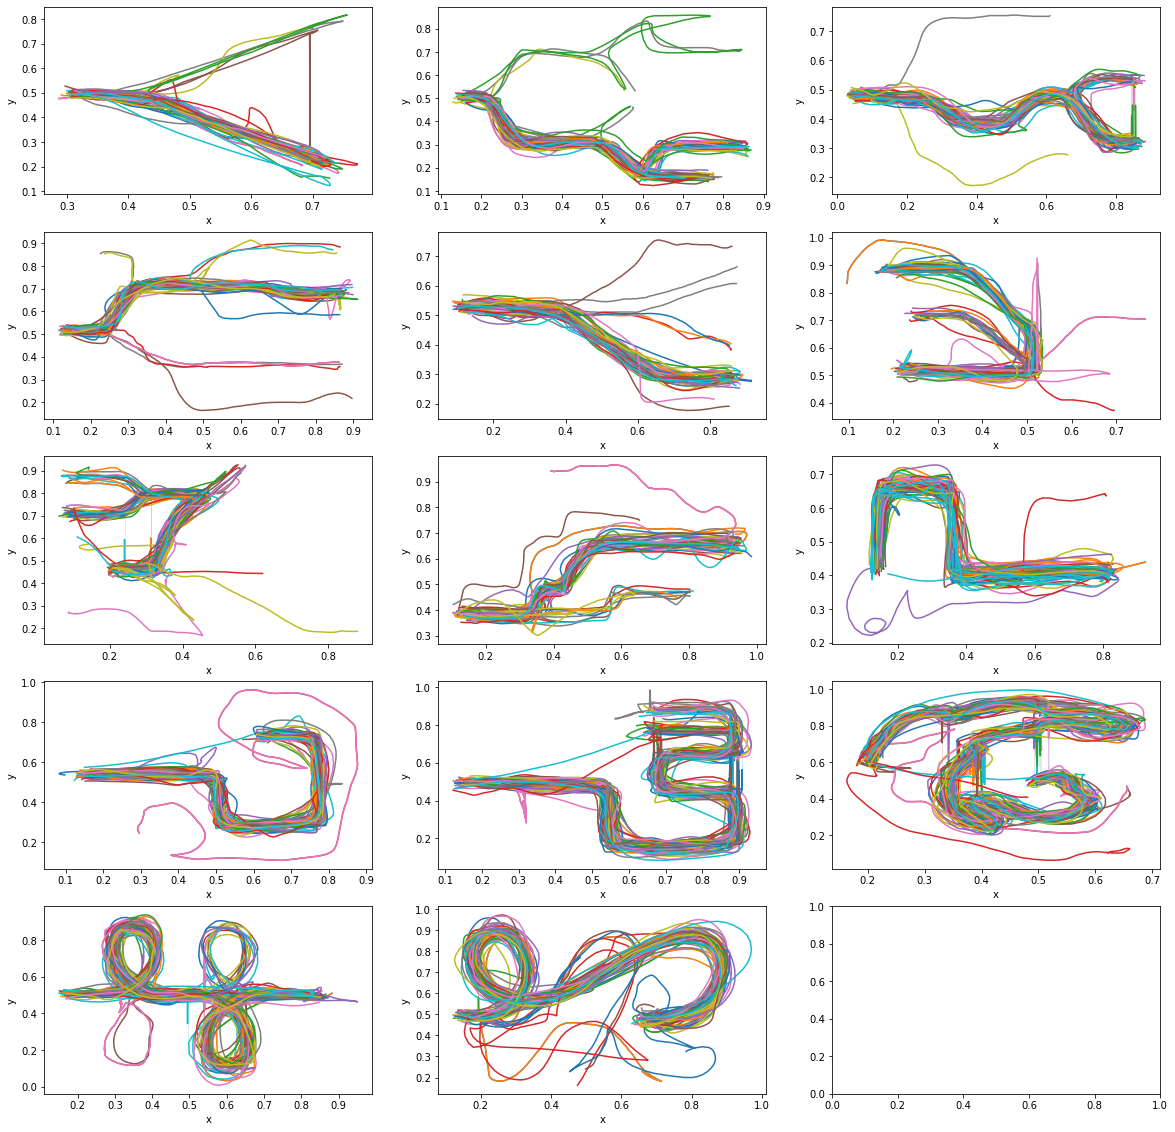

In [22]:
#Affichage des trajectoires du dataset
fig, axis = plt.subplots(5, 3)
fig.set_size_inches(20, 20)
for challenge in range(len(session[0].sorted_activities[0].challenges)):
    for i in range(0, qtd_samples):
        plot_challenges(session[i], challenge, axis[challenge // 3, challenge % 3])

Calcul de la matrice de distance

In [23]:
#metriques

def hausdorff(u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

def distance_calc(tra_list):
    traj_count = len(tra_list)
    D = np.zeros((traj_count, traj_count))

    #This may take a while
    for i in range(traj_count):
        for j in range(i + 1, traj_count):
            distance = hausdorff(tra_list[i], tra_list[j])
            D[i, j] = distance
            D[j, i] = distance
    return D;

In [24]:
# DBSCAN Functions
def plot_cluster_DBSCAN(D, eps:float, traj_lst, axs, i:int, challenge:int):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    eps = eps/100
    mdl = DBSCAN(eps=eps, min_samples=1)
    cluster_lst = mdl.fit_predict(D)

    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        axs[i].set_title(f"ep = {eps}, n_clusters = {cluster_count}")
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            axs[i].plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            axs[i].plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])

    list_users = []
    for i in range(len(mdl.labels_)):
        list_users.append([session[i].student_id, mdl.labels_[i], challenge, eps])
    df = pd.DataFrame(list_users, columns = ['student_id', 'cluster', 'challenge', 'epsilon'])
    #list_of_dfs=pd.concat([list_of_dfs, df], ignore_index=True)
    return(df)

def n_clusters_ep_DBSCAN(D, eps:float):
    eps = eps/100
    mdl = DBSCAN(eps=eps, min_samples=1)
    cluster_lst = mdl.fit_predict(D)
    cluster_count = np.max(cluster_lst) + 1
    
    list_n_clusters.append(cluster_count)
    list_eps.append(eps)

Clustering test round

C:\Users\miche\AppData\Local\Temp/ipykernel_6264/1033311003.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots()


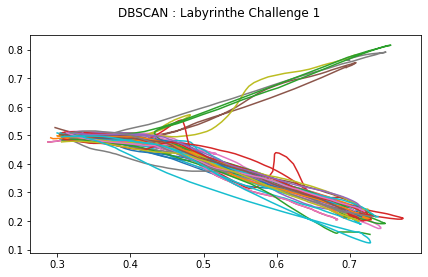

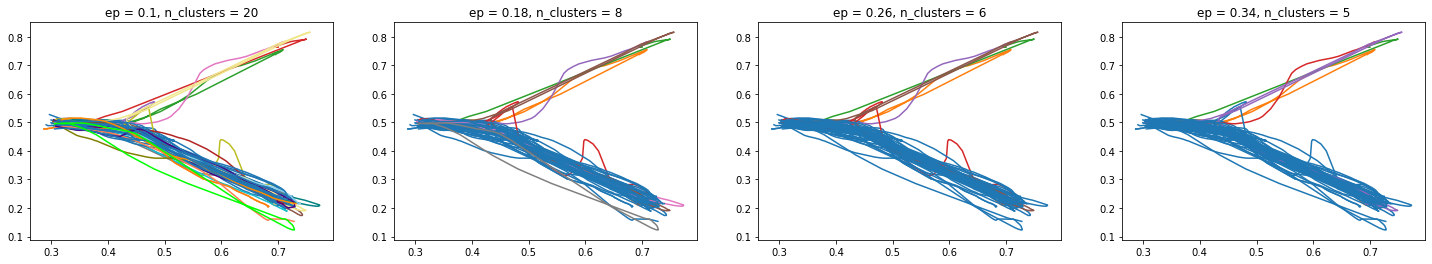

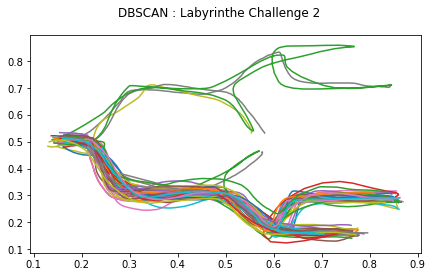

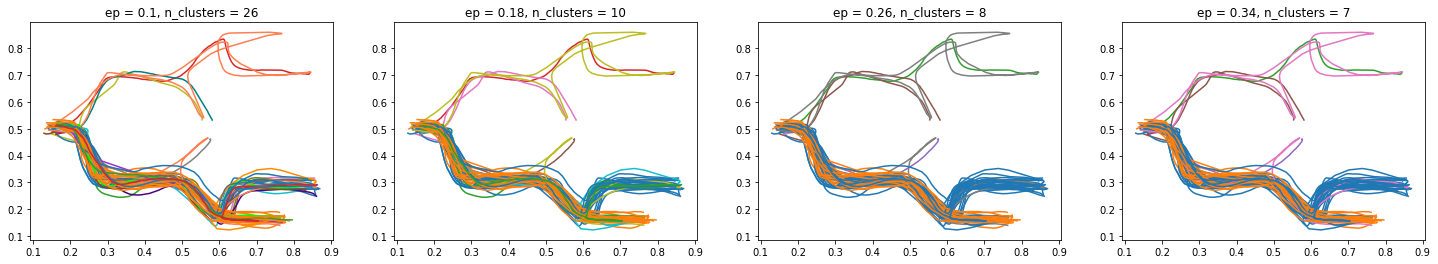

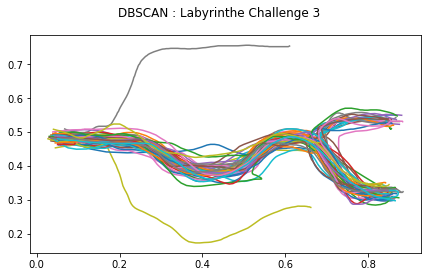

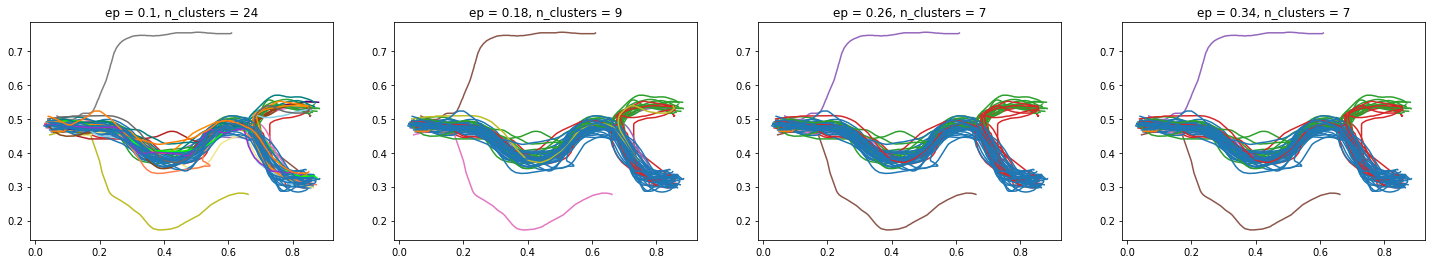

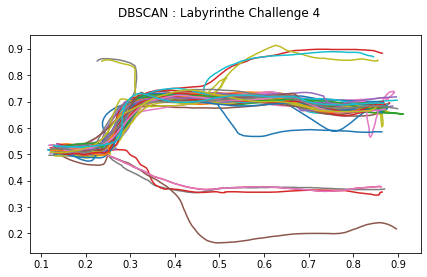

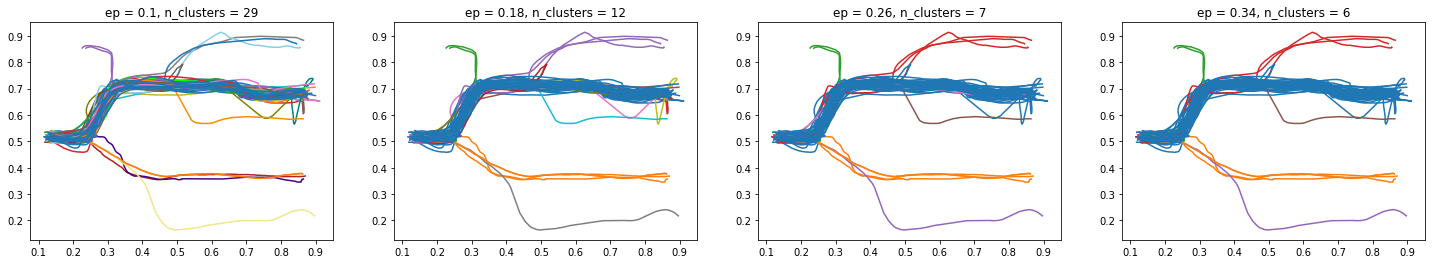

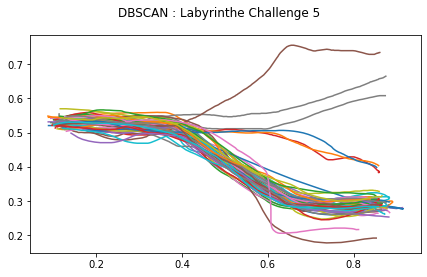

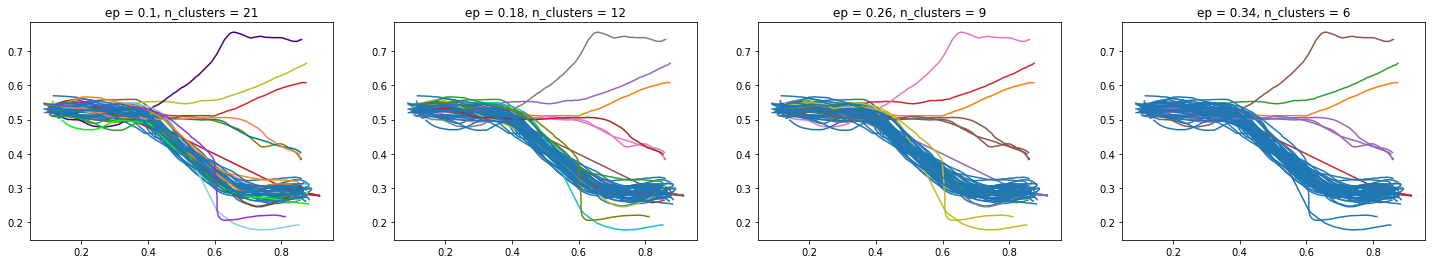

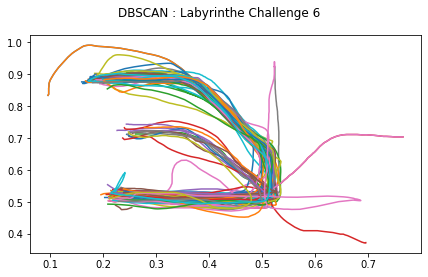

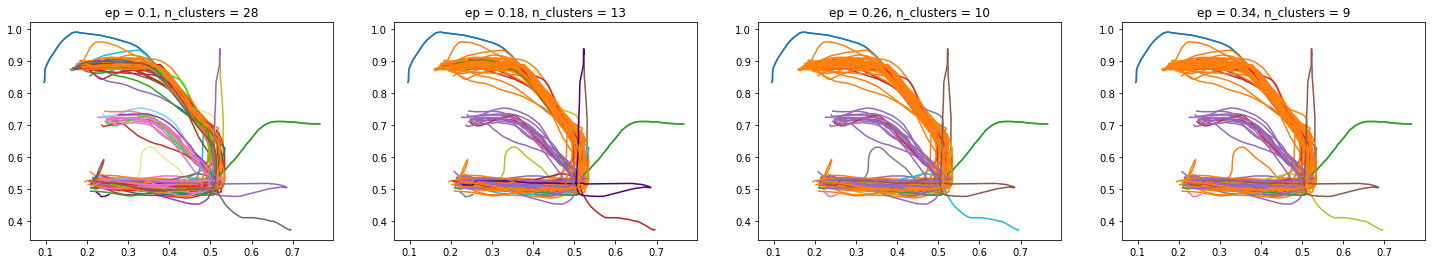

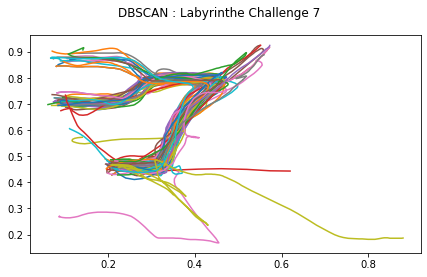

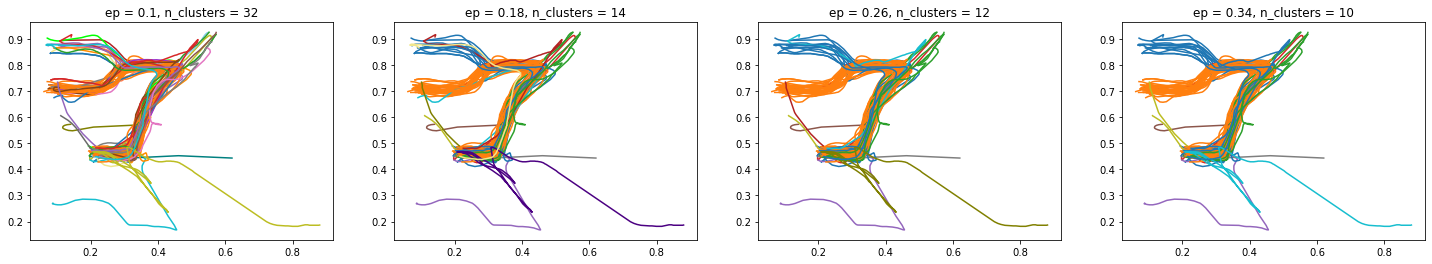

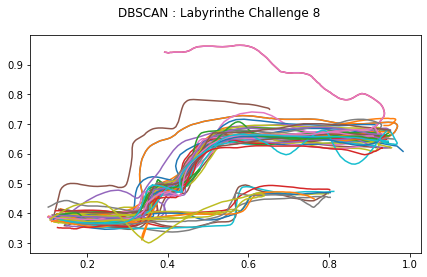

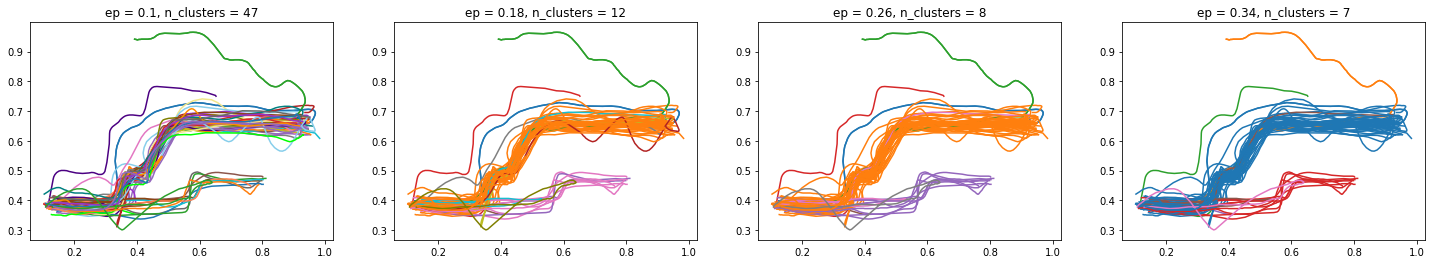

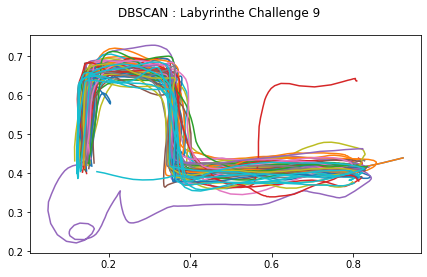

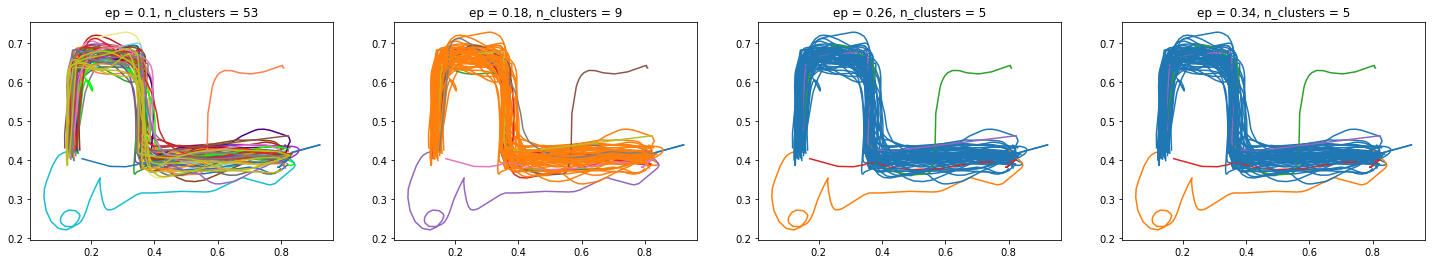

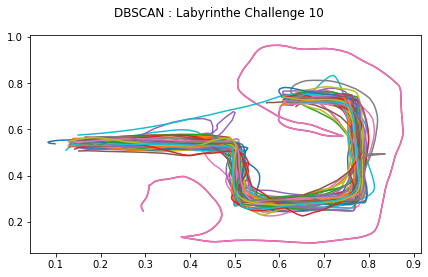

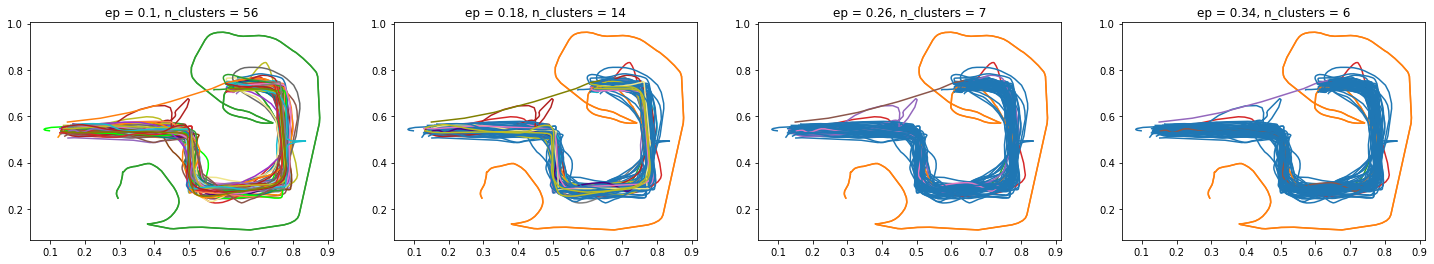

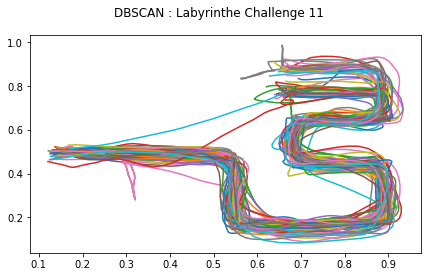

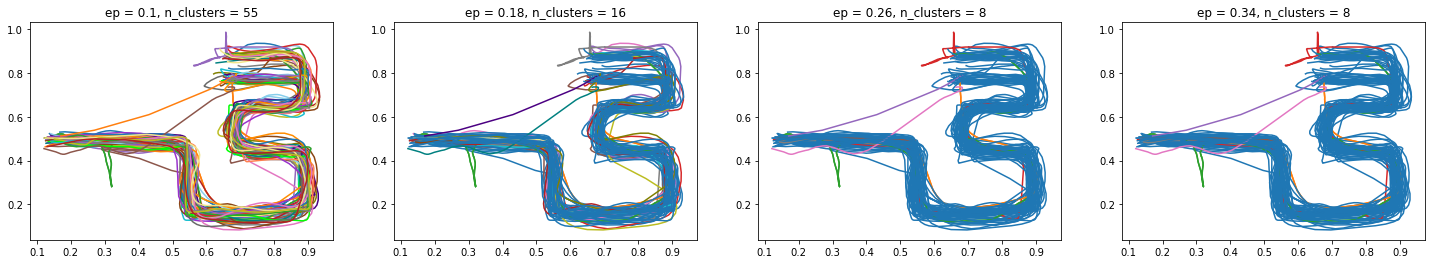

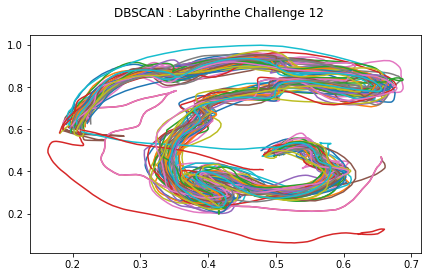

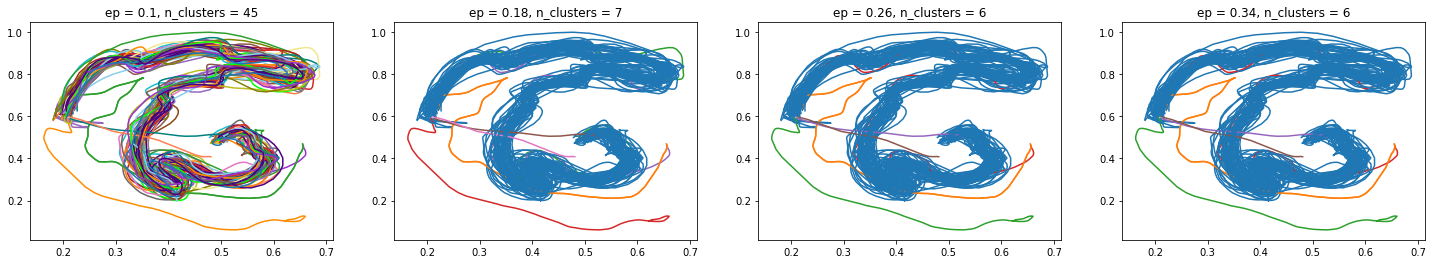

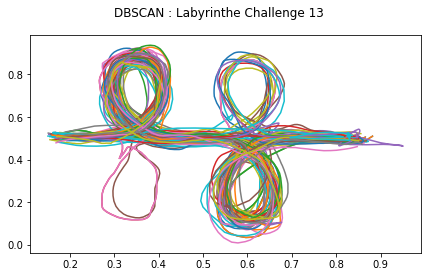

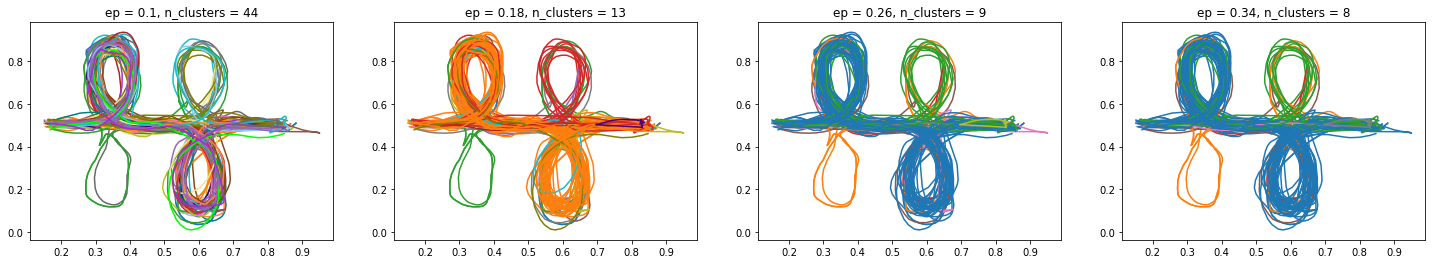

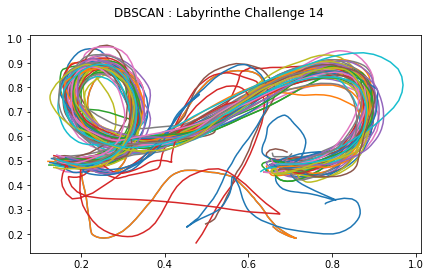

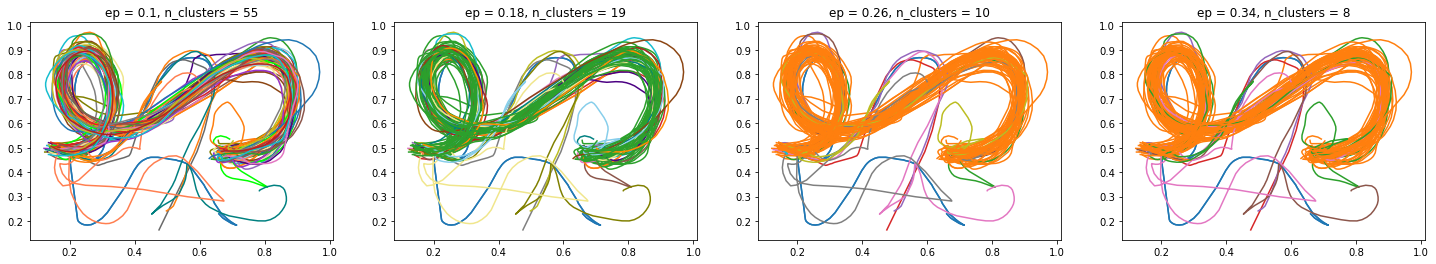

In [33]:
#Test round plot clusters
list_df_user_grupe_challenge = list()
df_user_grupe_challenge = list()
for challenge in range (qtd_challenges) :
    tra_list = list_track_challenge(challenge)

    fig, axs = plt.subplots()
    fig.set_size_inches(7, 4)
    fig.suptitle(f'DBSCAN : Labyrinthe Challenge {challenge+1}')

    #plot original figure
    for traj in tra_list :
        plt.plot(traj[:, 0], traj[:, 1])

    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(25, 4)
    axs.flatten();
    #4 DBScan initial epsilon 
    myeps = 0.10 * 100

    reduction_trajectoire_N1(tra_list)
    D = distance_calc(tra_list)

    
    for i in range(len(axs)) :
        df_user_grupe_challenge = plot_cluster_DBSCAN(D, myeps, tra_list, axs, i, challenge)
        myeps = myeps + 0.08 * 100;
        list_df_user_grupe_challenge.append(df_user_grupe_challenge)

    dftotal = pd.concat(list_df_user_grupe_challenge, axis = 0)
    dftotal.to_csv("logs_trajectories_clustering/challenge_%s.csv"%int(challenge+1), index = False)
    list_df_user_grupe_challenge.clear()


Test round du nombre de clusters en fonction d'epilison

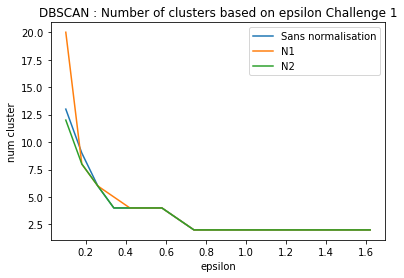

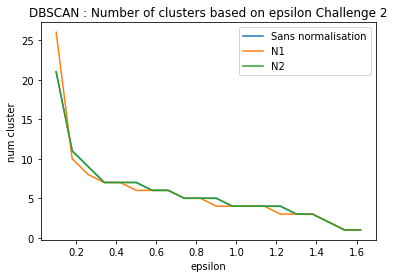

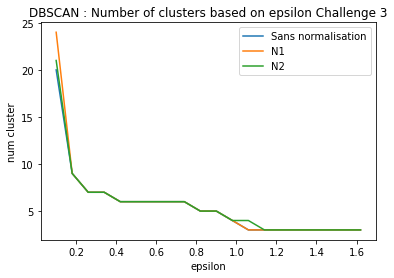

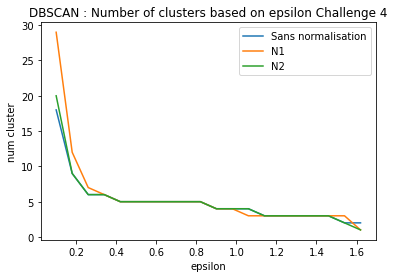

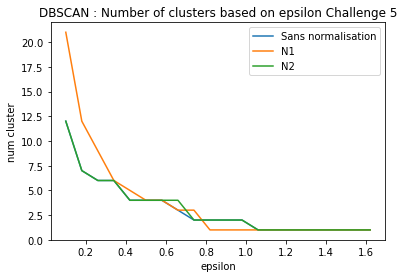

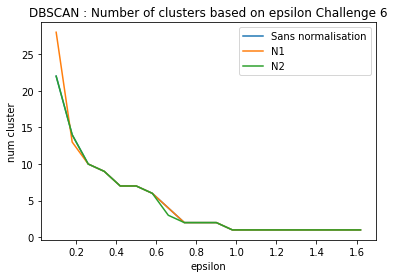

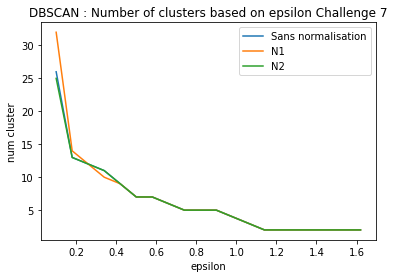

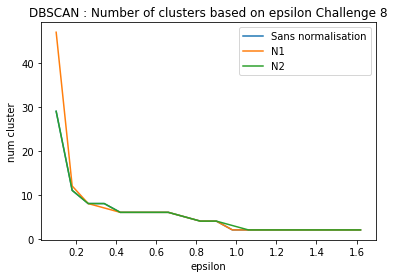

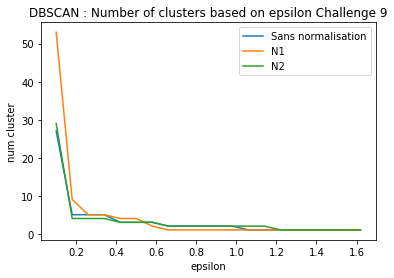

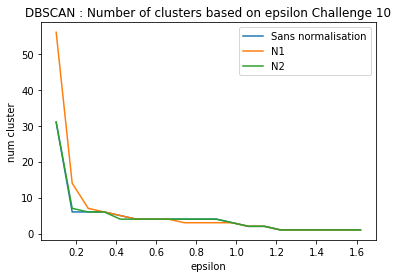

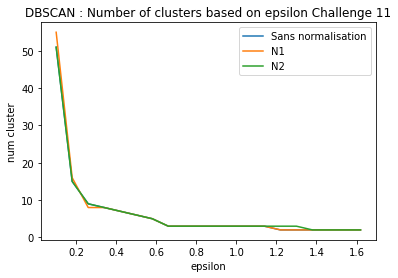

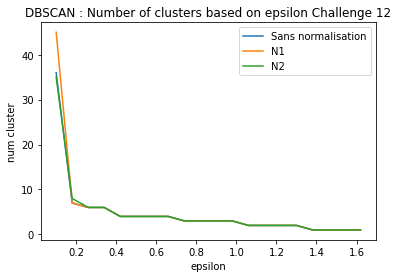

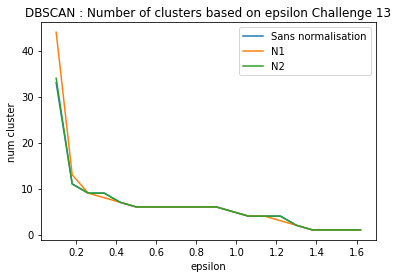

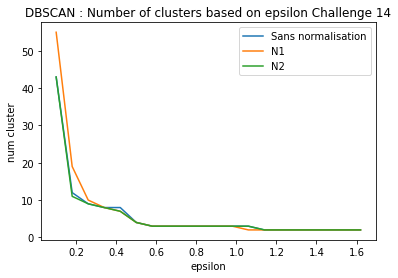

In [26]:
rounds = 20;

for challenge in range (qtd_challenges):
    for type_clus in range (3):
        list_n_clusters.clear()
        list_eps.clear()
        tra_list.clear()
        color_line = color_lst[type_clus]

        tra_list = list_track_challenge(challenge)
        #4 DBScan
        
        if (type_clus == 0) :
            label = "Sans normalisation"

        elif (type_clus == 1) : 
            label = "N1"
            #pour savoir la qt de points d'une traj avant la normalization
            #print(len(tra_list[challenge])) 
            teste = reduction_trajectoire_N1(tra_list)
            #points après la normalisation
            #print(len(tra_list[challenge])) 
            
        elif (type_clus == 2) :
            label = "N2"
            #print(len(tra_list[1]))
            for i in range(len(tra_list)):
                tra_list[i] = reduction_trajectoire_N2(tra_list[i])
            #print(len(tra_list[1]))
        
        D = distance_calc(tra_list)

        myeps = 0.10 * 100
        for i in range(rounds):
            n_clusters_ep_DBSCAN(D, myeps)
            myeps = myeps + 0.08 * 100;
            
        #plt.scatter(list_eps, list_n_clusters, color='black') 
        plt.plot(list_eps, list_n_clusters, label=label, linestyle='solid')
        plt.title(f'DBSCAN : Number of clusters based on epsilon Challenge {challenge+1}')
        plt.xlabel("epsilon")
        plt.ylabel("num cluster")
    plt.legend()
    plt.show()

### Exploration de calcul de vitesse de mouvement

In [27]:
def calculateSpeed(game_session : GameSession, challenge : int):
    digit_inputs = game_session.to_dataframe().sort_values(by=["ts"], ascending=True)
    timestamp = digit_inputs.loc[(digit_inputs["activity"] == "CrocosMaze") & (digit_inputs["challenge"] == float(challenge)),("ts")]
    duree = timestamp.iloc[-1] - timestamp.iloc[0]
    print(timestamp.iloc[-1])
    print(timestamp.iloc[0])
    vitesse = calculateDistance(game_session, challenge)/duree
    return(vitesse)



In [28]:
def tableVitesses () :
    import traja
    curve = pd.DataFrame.from_records([{"x": point[0], "y": point[1], "time": point[2]} for point in game_session.sorted_activities[0].challenges[11].digit_curve()])
    traj = traja.TrajaDataFrame(curve)

    data = []
    for i in range(1,qtd_samples):
        game_session = GameSession.from_json(os.path.join("..", "tests", "game_session", "dummy_data", "logs", str(i) + ".json"))
        for challenge in range(len(game_session.sorted_activities[0].challenges)):
            curve = pd.DataFrame.from_records([{"x": point[0], "y": point[1], "time": point[2]} for point in game_session.sorted_activities[0].challenges[11].digit_curve()])
            traj = traja.TrajaDataFrame(curve)
            data.append(traj)

    traja.trajectory.get_derivatives(data[2])

In [29]:
def time_per_sec(x: int):
    return np.sqrt(x)